In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [9]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [10]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(120),
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder(train_dir, transform=transforms)
validset = torchvision.datasets.ImageFolder(valid_dir, transform=transforms)
testset = torchvision.datasets.ImageFolder(test_dir, transform=transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=True)

In [4]:
label_title = ["melanoma", "nevus", "seborrheic_keratosis"]

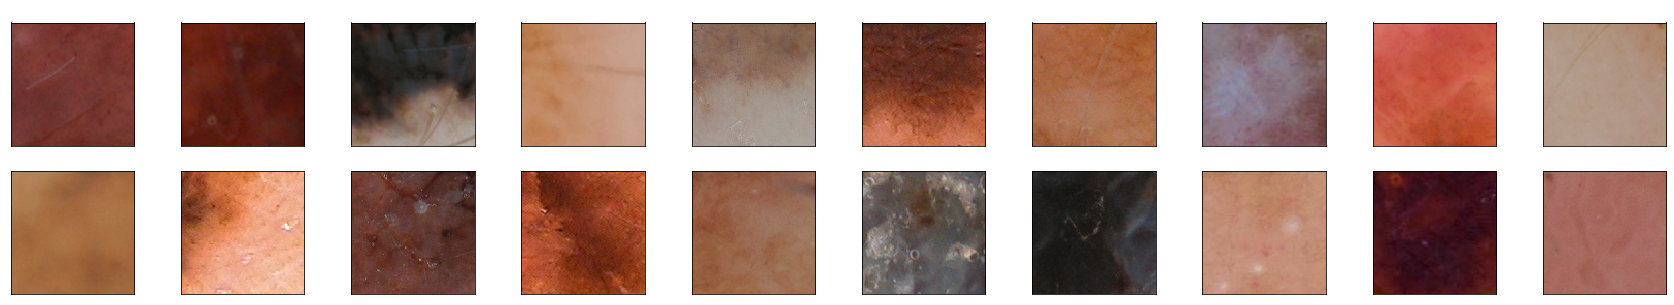

In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(30, 5))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(label_title[labels[i].item()], color='w')

In [6]:
model = torchvision.models.densenet201(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False
    
in_feat = model.classifier.in_features
model.classifier = torch.nn.Linear(in_feat, 3)

model.classifier

Linear(in_features=1920, out_features=3, bias=True)

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.01)

In [8]:
epochs = 10
valid_inf = np.Inf

for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
    
    model.eval()
    for batch_idx, (data, target) in enumerate(validloader):
        
        output = model.forward(data)
        loss = criterion(output, target)
        valid_loss += valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
    
    if valid_loss <= valid_inf:
        torch.save(model.state_dict(), 'skin_cancer_model.pt')
        valid_inf = valid_loss

Epoch: 1 	Training Loss: 50024145521475584.000000 	Validation Loss: 56.840385
Epoch: 2 	Training Loss: 29540978335416320.000000 	Validation Loss: 53.197754
Epoch: 3 	Training Loss: 25936388377542656.000000 	Validation Loss: 72.268799
Epoch: 4 	Training Loss: 34989213069869056.000000 	Validation Loss: 74.669853
Epoch: 5 	Training Loss: 33196931807182848.000000 	Validation Loss: 51.685463
Epoch: 6 	Training Loss: 21560787365527552.000000 	Validation Loss: 53.281910
Epoch: 7 	Training Loss: 25999451382349824.000000 	Validation Loss: 80.844238
Epoch: 8 	Training Loss: 29404877264257024.000000 	Validation Loss: 83.616859
Epoch: 9 	Training Loss: 36393147684618240.000000 	Validation Loss: 72.984879
Epoch: 10 	Training Loss: 25771749396185088.000000 	Validation Loss: 90.065918


In [13]:
model.load_state_dict(torch.load('skin_cancer_model.pt'))

<All keys matched successfully>

In [14]:
test_loss = 0.0
correct = 0.0
total = 0.0

model.eval()
for batch_idxch_idx, (data, target) in enumerate(testloader):
    
    output = model.forward(data)
    loss = criterion(output, target)
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    pred = output.data.max(1, keepdim=True)[1]
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
            
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

Test Loss: 2.093345


Test Accuracy: 48% (167/347)


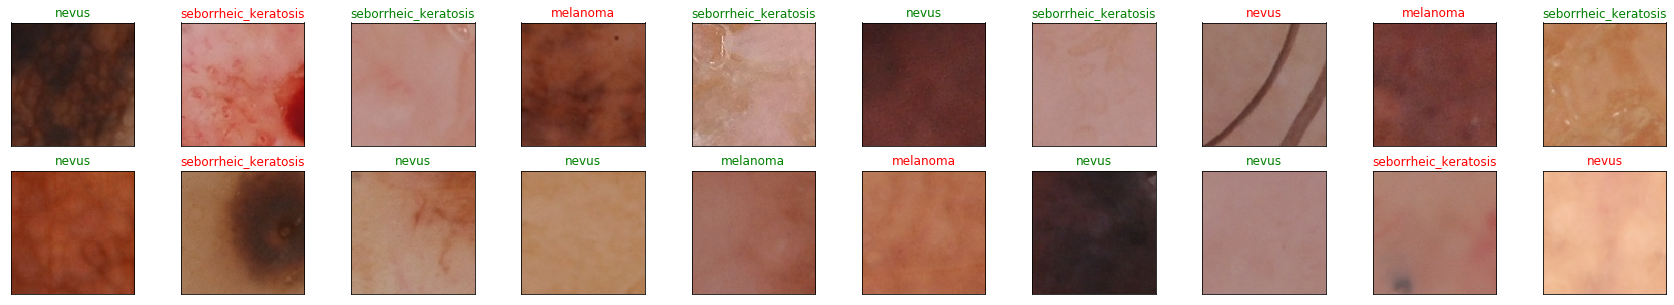

In [58]:
dataiter = iter(testloader)
images, labels = next(dataiter)

out = model.forward(images)
prediction = out.data.max(1)[1]

fig = plt.figure(figsize=(30, 5))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    if prediction[i].item() == labels[i].item():
        ax.set_title(label_title[prediction[i].item()], color='g')
    else:
        ax.set_title(label_title[prediction[i].item()], color='r')